# Model

### imports

In [1]:
import polars as pl
from polars import col as c
import os
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
from catboost import CatBoostRegressor
import shap
import pandas as pd
from numpy.typing import ArrayLike, NDArray
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import holidays

/Users/hq-n2y0j7g2k4/Documents/ml-engineer-greenscreens/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### constants

In [2]:
DATA_DIR = "dataset"
US_HOLIDAYS = holidays.US()  # this is a dict-like object

### functions

In [3]:
def mape_f(y_true: ArrayLike, y_pred: ArrayLike) -> np.floating:
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    metric = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return round(metric, 2)

### data

In [123]:
path = os.path.join("../", DATA_DIR, "train_df.parquet")
train_df = pl.read_parquet(path)

path = os.path.join("../", DATA_DIR, "eval_df.parquet")
eval_df = pl.read_parquet(path)

path = os.path.join("../", DATA_DIR, "validation.parquet")
validation = pl.read_parquet(path)

path = os.path.join("../", DATA_DIR, "test.parquet")
test = pl.read_parquet(path)
test = test.with_columns(pl.lit(0).cast(pl.Float64).alias("rate"))

In [5]:
train_df.sample()

rate,valid_miles,transport_type,weight,pickup_date,origin_kma,destination_kma,year,date,is_holiday_next_week,is_holiday,weight_mile,weight_per_mile,kma_pair,kma_track,kma_transport_rate_median,kma_track_miles_median,kma_track_rate_median,shifted_week_rate,shifted_trend,rolling_mean_demand,month_sin,month_cos,weekday_sin,weekday_cos,week_sin,week_cos
f64,f64,str,f64,datetime[μs],str,str,i32,date,i64,i64,f64,f64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2.5414,6.80254,"""MKPFX""",39950.0,2021-10-24 10:42:00,"""QUERU""","""RCDSS""",2021,2021-10-24,0,0,3.5960e7,44.382444,"""QUERU_RCDSS""","""QUERU_RCDSS""",2.5414,6.80254,2.5414,2.5414,4.244306,466.0,-0.866025,0.5,-2.4493e-16,1.0,-0.964636,0.263587


### model

In [163]:
def xy_split(
    data: pl.DataFrame,
    target: str = "rate",
) -> tuple[pd.DataFrame, pd.DataFrame]:
    X = data.drop(
        [
            "date",
            "pickup_date",
            # "hour",
            # "kma_pair",
            # "origin_kma",
            # "destination_kma",
            target,
            "kma_transport_rate_median",
            # "kma_track_rate_median",
            # "rolling_rate_diff",
        ]
    ).to_pandas()
    y = data[target].to_pandas()
    return X, y

In [164]:
CATEGORICAL_FEATURES = [
    "transport_type",
    "origin_kma",
    "destination_kma",
    "kma_pair",
    "kma_track",
    # "month",
    # "weekday",
    # "week",
    "year",
    "is_holiday",
    "is_holiday_next_week",
]

In [165]:
def fit_and_eval_catboost(
    train_df: pl.DataFrame,
    eval_df: pl.DataFrame,
    test_df: pl.DataFrame,
) -> CatBoostRegressor:

    X_train, y_train = xy_split(train_df)
    X_eval, y_eval = xy_split(eval_df)
    X_test, y_test = xy_split(test_df)

    model = CatBoostRegressor(
        random_seed=1984,
        cat_features=CATEGORICAL_FEATURES,
        eval_metric="SMAPE",
        # loss_function="MAPE",
        depth=3,
        iterations=500,
        learning_rate=0.06,
        # thread_count=16,
        # used_ram_limit="128GB",
    )

    model.fit(
        X=X_train,
        y=y_train,
        verbose=True,
        early_stopping_rounds=50,
        eval_set=(
            X_eval,
            y_eval,
        ),
    )

    predicted = model.predict(X_test)
    predicted[predicted <= 0] = 0

    result_df = pd.DataFrame(
        {
            "preds": predicted,
            "fact": y_test,
        }
    )

    metric = mape_f(
        result_df.fact,
        result_df.preds,
    )
    print("CatBoost MAPE:", metric)

    explainer = shap.TreeExplainer(model)
    shap_values = explainer(X_train)
    shap.plots.beeswarm(shap_values, plot_size=(8, 5))
    plt.show()

    return model, result_df

0:	learn: 31.9266245	test: 31.4092365	best: 31.4092365 (0)	total: 56.4ms	remaining: 28.1s
1:	learn: 30.5408990	test: 30.0842890	best: 30.0842890 (1)	total: 92.4ms	remaining: 23s
2:	learn: 29.2231168	test: 28.9182658	best: 28.9182658 (2)	total: 139ms	remaining: 23s
3:	learn: 27.9861157	test: 27.7915265	best: 27.7915265 (3)	total: 183ms	remaining: 22.7s
4:	learn: 26.8787773	test: 26.8369605	best: 26.8369605 (4)	total: 214ms	remaining: 21.2s
5:	learn: 25.7970200	test: 25.9167316	best: 25.9167316 (5)	total: 247ms	remaining: 20.3s
6:	learn: 24.7431031	test: 24.9994246	best: 24.9994246 (6)	total: 278ms	remaining: 19.5s
7:	learn: 23.7447591	test: 24.1594919	best: 24.1594919 (7)	total: 313ms	remaining: 19.3s
8:	learn: 22.8957790	test: 23.4505351	best: 23.4505351 (8)	total: 348ms	remaining: 19s
9:	learn: 22.0843522	test: 22.7554383	best: 22.7554383 (9)	total: 378ms	remaining: 18.5s
10:	learn: 21.2570552	test: 22.0760165	best: 22.0760165 (10)	total: 405ms	remaining: 18s
11:	learn: 20.4590506	tes

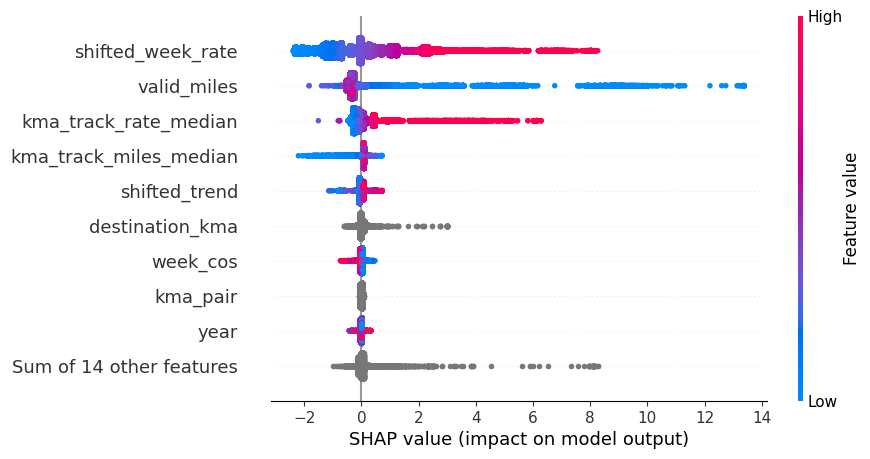

In [166]:
model, result_df = fit_and_eval_catboost(train_df, eval_df, validation)

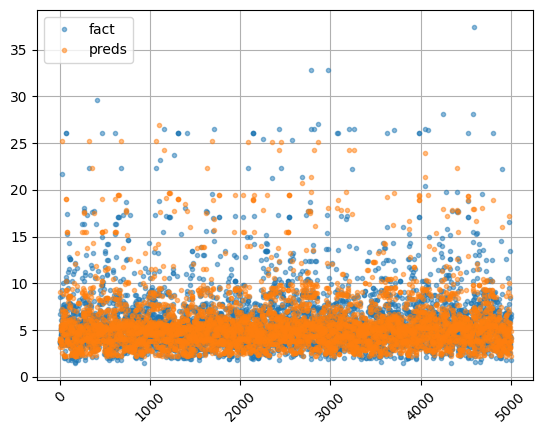

In [167]:
plt.plot(result_df["fact"], ".", alpha=0.5, label="fact")
plt.plot(result_df["preds"], ".", alpha=0.5, label="preds")
plt.legend()
# plt.xlabel("date")
plt.xticks(rotation=45)
plt.grid()

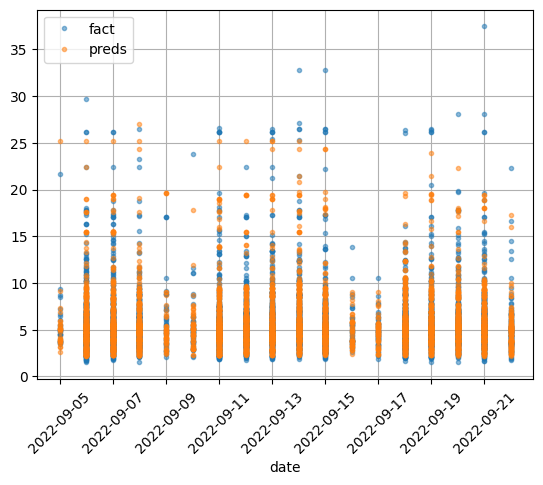

In [168]:
plt.plot(validation["date"], result_df["fact"], ".", alpha=0.5, label="fact")
plt.plot(validation["date"], result_df["preds"], ".", alpha=0.5, label="preds")
plt.legend()
plt.xlabel("date")
plt.xticks(rotation=45)
plt.grid()

In [169]:
# under-prognosis
sum(result_df["fact"] - result_df["preds"])

1519.5831386367288

In [170]:
# under-prognosis
sum((result_df["fact"] - result_df["preds"]) / result_df["fact"])

90.06232473551117

In [145]:
mape_f(
    result_df.fact,
    result_df.preds,
)

13.32

- It seems that predictions are quite good
- However the predictions are not better than baseline (variant over categories for validation dataset)
- probably this behaviour is the consequence of noisy data or bad lag features (it might have been better to predict averaged statistics over categories instead of lags)

### grid search

In [33]:
model = CatBoostRegressor(
    random_seed=1984,
    cat_features=CATEGORICAL_FEATURES,
    eval_metric="MAPE",
    # loss_function="MAPE",
    depth=3,
    iterations=500,
    learning_rate=0.06,
    # thread_count=16,
    # used_ram_limit="128GB",
)

In [34]:
param_grid = {
    "depth": [2, 3, 4, 5],
    "iterations": [100, 200, 400],
    "learning_rate": [0.01, 0.02, 0.05, 0.09],
}

In [35]:
tscv = TimeSeriesSplit(n_splits=3)
gsearch = GridSearchCV(
    estimator=model,
    cv=tscv,
    param_grid=param_grid,
    scoring="neg_mean_absolute_percentage_error",
    n_jobs=4,
)

In [ ]:
gsearch.fit(*xy_split(train_df))

In [ ]:
# gs.best_params_
# {'depth': 5, 'iterations': 400, 'learning_rate': 0.05}

In [ ]:
# grid search did not significantly improve the metrics

### inference

In [127]:
model, result_df = fit_and_eval_catboost(train_df.vstack(eval_df), validation, test)

0:	learn: 32.0052757	test: 31.1042908	best: 31.1042908 (0)	total: 83.3ms	remaining: 41.6s
1:	learn: 30.6152817	test: 29.9530116	best: 29.9530116 (1)	total: 205ms	remaining: 51.1s
2:	learn: 29.2998475	test: 28.8289436	best: 28.8289436 (2)	total: 390ms	remaining: 1m 4s
3:	learn: 28.1199867	test: 27.9419373	best: 27.9419373 (3)	total: 464ms	remaining: 57.5s
4:	learn: 26.9789210	test: 26.9623644	best: 26.9623644 (4)	total: 540ms	remaining: 53.5s
5:	learn: 25.8558034	test: 26.0498421	best: 26.0498421 (5)	total: 646ms	remaining: 53.2s
6:	learn: 24.9472444	test: 25.3037819	best: 25.3037819 (6)	total: 714ms	remaining: 50.3s
7:	learn: 23.9390515	test: 24.4455895	best: 24.4455895 (7)	total: 795ms	remaining: 48.9s
8:	learn: 23.0122297	test: 23.6822505	best: 23.6822505 (8)	total: 856ms	remaining: 46.7s
9:	learn: 22.1128636	test: 22.9763013	best: 22.9763013 (9)	total: 926ms	remaining: 45.4s
10:	learn: 21.3248182	test: 22.3496221	best: 22.3496221 (10)	total: 993ms	remaining: 44.1s
11:	learn: 20.5492

/var/folders/v_/vqhfnf3s4sb7g6nfby7hc9sr0000gn/T/ipykernel_11050/3086022879.py:3: RuntimeWarning: divide by zero encountered in divide
  metric = np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [138]:
(
    test.select(
        "valid_miles",
        "transport_type",
        "weight",
        "pickup_date",
        "origin_kma",
        "destination_kma",
    ).with_columns(
        pl.Series(
            name="rate_forecast",
            values=result_df["preds"].round(4).to_list(),
        )
    )
    # .write_csv("../dataset/forecast.csv")
)